## Import dependencies

In [1]:
# Download detr repos
!git clone https://github.com/facebookresearch/detr.git 

Cloning into 'detr'...
remote: Enumerating objects: 243, done.
remote: Total 243 (delta 0), reused 0 (delta 0), pack-reused 243
Receiving objects: 100% (243/243), 12.84 MiB | 12.67 MiB/s, done.
Resolving deltas: 100% (128/128), done.


In [2]:
!pip install utils
!pip install --upgrade pip

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
     |████████████████████████████████| 1.5 MB 883 kB/s eta 0:00:01
  Attempting uninstall: pip
    Found existing installation: pip 20.1.1
    Uninstalling pip-20.1.1:
      Successfully uninstalled pip-20.1.1


In [3]:
# basic
import os
import numpy as np 
import pandas as pd 
from datetime import datetime
import time
import random
from tqdm.autonotebook import tqdm

#computer vison module
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

#pytorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler

#for K-fold cross validation
from sklearn.model_selection import StratifiedKFold

#Hungarian loss & bipartite matcher
import sys
sys.path.append('./detr/')

from detr.models.matcher import HungarianMatcher
from detr.models.detr import SetCriterion

#Data aug
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

#Glob
from glob2 import glob

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  


# Data pre-processing

In [4]:
train_dir = '../input/global-wheat-detection/train/'
test_dir = '../input/global-wheat-detection/test/'

train_annos = '../input/global-wheat-detection/train.csv'

# glob to get lists of files of each dir 
train_fns = glob(train_dir + '*')
test_fns = glob(test_dir + '*')

In [5]:
print('Number of train images: ', len(train_fns))
print('Number of test images: ', len(test_fns))

Number of train images:  3422
Number of test images:  10


In [6]:
train = pd.read_csv(train_annos)

#Create dataframe with all training images
all_train_images = pd.DataFrame([fns.split('/')[-1][:-4] for fns in train_fns])
all_train_images.columns=['image_id']

#Merge with bboxes
all_train_images = all_train_images.merge(train, on='image_id', how='left')

#Fill nan values with zero
all_train_images['bbox'] = all_train_images.bbox.fillna('[0,0,0,0]')

#Split 4 values of bbox to columns
bbox_items = all_train_images.bbox.str.split(',', expand = True)

all_train_images['x_min'] = bbox_items[0].str.strip('[ ').astype(float)
all_train_images['y_min'] = bbox_items[1].str.strip(' ').astype(float)
all_train_images['width'] = bbox_items[2].str.strip(' ').astype(float)
all_train_images['height'] = bbox_items[3].str.strip('] ').astype(float)

In [7]:
# Check imgs without bboxes.
print('There are {} images with no bounding box!'.format(len(all_train_images)- len(train)))

There are 49 images with no bounding box!


In [8]:
# Remove img without bboxes.
all_train_images = all_train_images[all_train_images.width != 0]

print('There are {} images with no bounding box!'.format(len(all_train_images)- len(train)))

There are 0 images with no bounding box!


In [9]:
# This code is used for connecting boxes with id, we partly get from UIT LOGO baseline. 
def get_all_bboxes(df, image_id):
    image_bboxes = df[df.image_id == image_id]   
    bboxes = []
    for _,row in image_bboxes.iterrows():
        bboxes.append((row.x_min, row.y_min, row.width, row.height))
        
    return bboxes

def plot_image_examples(df, rows=3, cols=3):
    fig, axs = plt.subplots(rows, cols, figsize=(25,20))
    for row in range(rows):
        for col in range(cols):
            idx = np.random.randint(len(df), size=1)[0]
            img_id = df.iloc[idx].image_id
            
            img = Image.open(train_dir + img_id + '.jpg')
            axs[row, col].imshow(img)
            
            bboxes = get_all_bboxes(df, img_id)
            
            for bbox in bboxes:
                rect = patches.Rectangle((bbox[0],bbox[1]),bbox[2],bbox[3],linewidth=1,edgecolor='r',facecolor='none')
                axs[row, col].add_patch(rect)
            
            axs[row, col].axis('off')

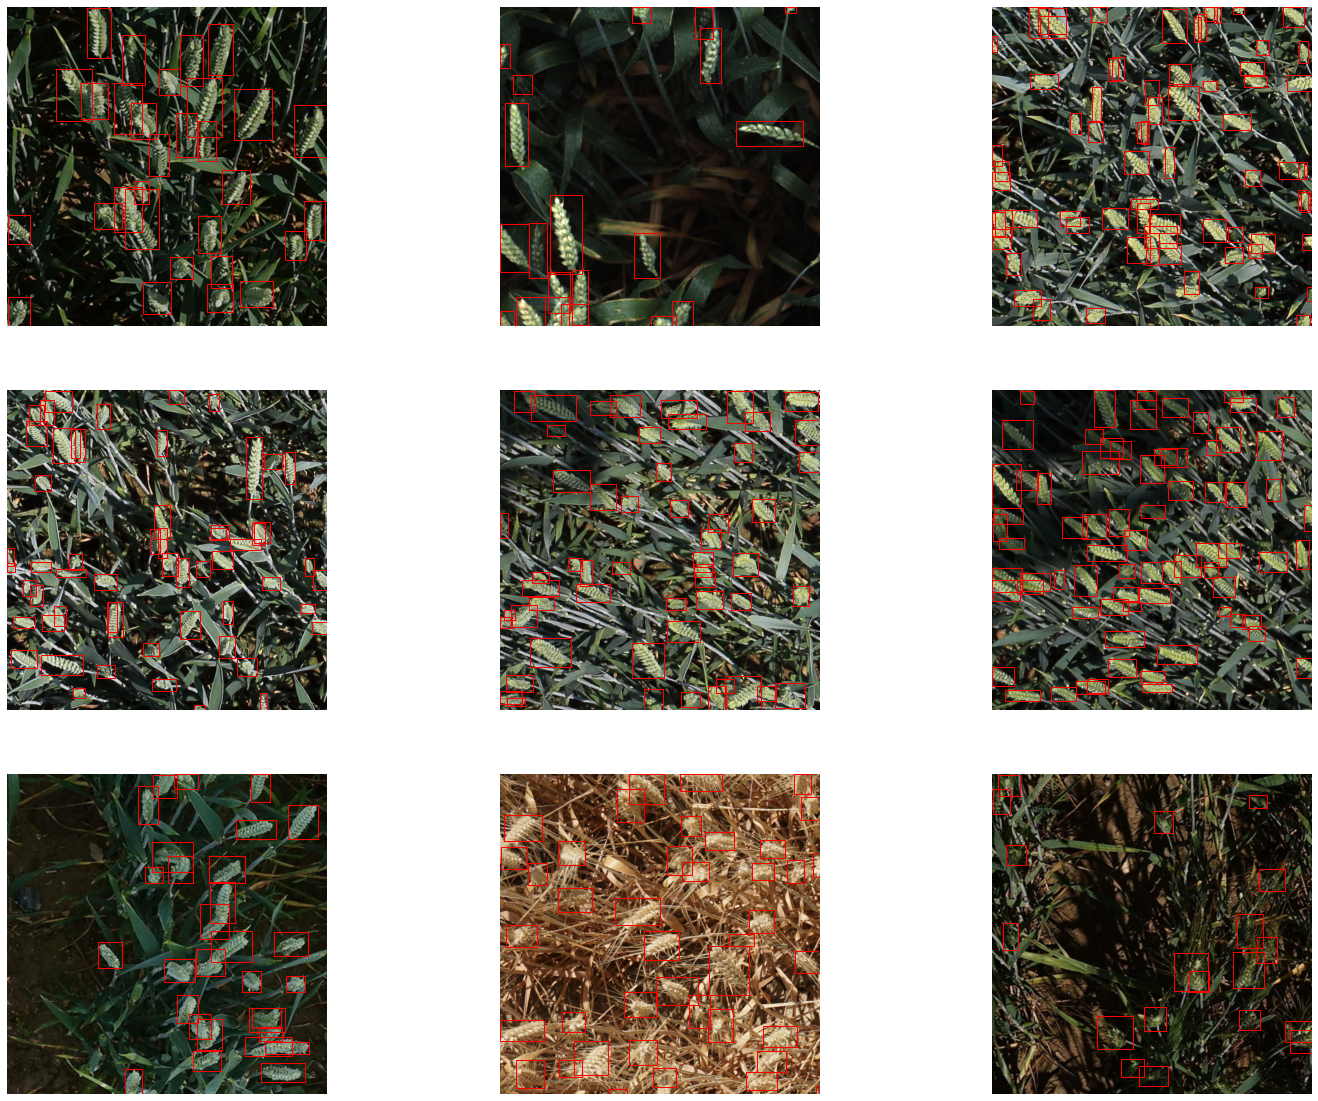

In [10]:
# Sample images with bounding box.
plot_image_examples(all_train_images)

In [11]:
# Drop old bbox column
all_train_images.drop(columns = ['bbox'], inplace=True)

# Count bbox with condition
all_train_images['count'] = all_train_images.apply(lambda row: 1 if np.isfinite(row.width) else 0, axis=1)

all_train_images

image_id  width  height     source  x_min  y_min  count
0       944c60a15   69.0    49.0  arvalis_1  336.0   54.0      1
1       944c60a15   79.0    45.0  arvalis_1  218.0    0.0      1
2       944c60a15   56.0    65.0  arvalis_1    2.0    0.0      1
3       944c60a15   71.0    96.0  arvalis_1  588.0  256.0      1
4       944c60a15   61.0    80.0  arvalis_1  257.0  251.0      1
...           ...    ...     ...        ...    ...    ...    ...
147837  667b4a999   67.0    94.0  arvalis_2  939.0   87.0      1
147838  667b4a999   62.0    75.0  arvalis_2   12.0  821.0      1
147839  667b4a999   64.0    72.0  arvalis_2  502.0  399.0      1
147840  667b4a999   46.0    68.0  arvalis_2  491.0  305.0      1
147841  667b4a999   63.0    78.0  arvalis_2  506.0  215.0      1

[147793 rows x 7 columns]

## Creating Fold

In [12]:
# Config
n_folds = 4
seed = 42
num_classes = 2 #(wheat and no-obj class)
num_queries = 100
null_class_coef = 0.5
BATCH_SIZE = 12
LR = 2e-5
EPOCHS = 10

In [13]:
skf = StratifiedKFold(n_splits= n_folds, shuffle=True, random_state=42)

df_folds = all_train_images[['image_id', 'count']].copy()

#Gather all boxes of each img 
df_folds = df_folds.groupby('image_id').count()

#Get source for each img, we stratify to 4 folds.
df_folds.loc[:, 'source'] = all_train_images[['image_id', 'source']].groupby('image_id').min()['source']

df_folds.loc[:, 'stratify_group'] = np.char.add(
    df_folds['source'].values.astype(str),
    df_folds['count'].apply(lambda x: f'_{x // 15}').values.astype(str)
    )

df_folds.loc[:, 'fold'] = 0

for fold_number, (train_index, val_index) in enumerate(skf.split(X=df_folds.index, y=df_folds['stratify_group'])):
    df_folds.loc[df_folds.iloc[val_index].index, 'fold'] = fold_number

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  % (min_groups, self.n_splits)), UserWarning)


In [14]:
df_folds

count     source stratify_group  fold
image_id                                        
00333207f     55  arvalis_1    arvalis_1_3     1
005b0d8bb     20    usask_1      usask_1_1     3
006a994f7     25    inrae_1      inrae_1_1     0
00764ad5d     41    inrae_1      inrae_1_2     0
00b5fefed     25  arvalis_3    arvalis_3_1     2
...          ...        ...            ...   ...
ffb445410     57     rres_1       rres_1_3     1
ffbf75e5b     52  arvalis_1    arvalis_1_3     1
ffbfe7cc0     34  arvalis_1    arvalis_1_2     2
ffc870198     41    usask_1      usask_1_2     3
ffdf83e42     39  arvalis_1    arvalis_1_2     3

[3373 rows x 4 columns]

## Create dataset object

In [15]:
# Code taken from Peter - Kaggle Grandmaster
class WheatDataset(Dataset):
    
    def __init__(self,image_ids,dataframe,transforms=None):
        self.image_ids = image_ids
        self.df = dataframe        
        
        #Data augmentation 
        self.transforms = transforms
        
        
    def __len__(self) -> int:
        return self.image_ids.shape[0]
    
    def __getitem__(self,index):
        image_id = self.image_ids[index]
        records = self.df[self.df['image_id'] == image_id]
        
        image = cv2.imread(f'{train_dir}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        
        # DETR takes in data in coco format 
        boxes = records[['x_min', 'y_min', 'width', 'height']].values
        
        #Area of bb
        area = boxes[:,2]*boxes[:,3]
        area = torch.as_tensor(area, dtype=torch.float32)
        
        labels =  np.zeros(len(boxes), dtype=np.int32)

        
        if self.transforms:
            sample = {
                'image': image,
                'bboxes': boxes,
                'labels': labels
            }
            sample = self.transforms(**sample)
            image = sample['image']
            boxes = sample['bboxes']
            labels = sample['labels']
            
            
        #Normalizing BBOXES            
        _,h,w = image.shape
        boxes = A.augmentations.bbox_utils.normalize_bboxes(sample['bboxes'],rows=h,cols=w)
        target = {}
        target['boxes'] = torch.as_tensor(boxes,dtype=torch.float32)
        target['labels'] = torch.as_tensor(labels,dtype=torch.long)
        target['image_id'] = torch.tensor([index])
        target['area'] = area
        
        return image, target, image_id

## Create DETR object

In [16]:
class DETRModel(nn.Module):
    def __init__(self,num_classes,num_queries):
        super(DETRModel,self).__init__()
        self.num_classes = num_classes
        self.num_queries = num_queries
        
        #Download pretrained DETR model with backbone resnet101 feature extractor.
        self.model = torch.hub.load('facebookresearch/detr', 'detr_resnet101', pretrained=True)
        self.in_features = self.model.class_embed.in_features
        
        self.model.class_embed = nn.Linear(in_features=self.in_features,out_features=self.num_classes)
        self.model.num_queries = self.num_queries
        
    def forward(self,images):
        return self.model(images)

In [17]:
#Create matcher for loss calculation and set "lambda" params
# loss_ce: classification loss (Hungarian matching loss)
# loss_bbox: bbox loss
# giou: giou loss

matcher = HungarianMatcher()

weight_dict = weight_dict = {'loss_ce': 1, 'loss_bbox': 1 , 'loss_giou': 1}

losses = ['labels', 'boxes', 'cardinality']

## Data Augmentation

In [18]:
def get_train_transforms():
    return A.Compose([A.OneOf([A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit= 0.2, val_shift_limit=0.2, p=0.9),                               
                      A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.9)],p=0.9),                      
                      A.ToGray(p=0.01),                      
                      A.HorizontalFlip(p=0.5),                      
                      A.VerticalFlip(p=0.5),                      
                      A.Resize(height=512, width=512, p=1),                      
                      A.Cutout(num_holes=8, max_h_size=64, max_w_size=64, fill_value=0, p=0.5),                      
                      ToTensorV2(p=1.0)],                      
                      p=1.0,                     
                      bbox_params=A.BboxParams(format='coco',min_area=0, min_visibility=0,label_fields=['labels'])
                      )


def get_valid_transforms():
    return A.Compose([A.Resize(height=512, width=512, p=1.0),
                      ToTensorV2(p=1.0)], 
                      p=1.0, 
                      bbox_params=A.BboxParams(format='coco',min_area=0, min_visibility=0,label_fields=['labels'])
                      )

## Loss calculation object

In [19]:
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [20]:
def train_fn(data_loader,model,criterion,optimizer,device,scheduler,epoch):
    
    model.train()
    criterion.train()
    
    summary_loss = AverageMeter()
    
    with tqdm(data_loader, total=len(data_loader)) as tk0:
    
        for step, (images, targets, image_ids) in enumerate(tk0):
        
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        

            output = model(images)
        
            loss_dict = criterion(output, targets)
            weight_dict = criterion.weight_dict
        
            losses = sum(loss_dict[k] * weight_dict[k] for k in loss_dict.keys() if k in weight_dict)
        
            optimizer.zero_grad()

            losses.backward()
            optimizer.step()
            
            if scheduler is not None:
                scheduler.step()
        
            summary_loss.update(losses.item(),BATCH_SIZE)
            tk0.set_postfix(loss=summary_loss.avg)
        
    return summary_loss

In [21]:
def eval_fn(data_loader, model,criterion, device):
    
    model.eval()
    criterion.eval()
    
    summary_loss = AverageMeter()
    
    # Disabled gradient calculation over the weights
    with torch.no_grad():
        
        tk0 = tqdm(data_loader, total=len(data_loader))
        for step, (images, targets, image_ids) in enumerate(tk0):
            
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            output = model(images)
        
            loss_dict = criterion(output, targets)
            weight_dict = criterion.weight_dict
        
            losses = sum(loss_dict[k] * weight_dict[k] for k in loss_dict.keys() if k in weight_dict)
            
            summary_loss.update(losses.item(),BATCH_SIZE)
            tk0.set_postfix(loss=summary_loss.avg)
    
    return summary_loss

# Training

In [22]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [23]:
def get_data_loader(fold):    
    df_train = df_folds[df_folds['fold'] != fold]
    df_valid = df_folds[df_folds['fold'] == fold]

    train_dataset = WheatDataset(
        image_ids=df_train.index.values,
        dataframe=all_train_images,
        transforms=get_train_transforms()
        )

    train_data_loader = DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=4,
        collate_fn=collate_fn
        )

    valid_dataset = WheatDataset(
        image_ids=df_valid.index.values,
        dataframe=all_train_images,
        transforms=get_valid_transforms()
        )

    valid_data_loader = DataLoader(
        valid_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=4,
        collate_fn=collate_fn
        )
    
    return train_data_loader, valid_data_loader

In [24]:
def trainnnn(train_data_loader, valid_data_loader, device, model, criterion, optimizer, fold, best_loss, index):
    for epoch in range(EPOCHS):
        train_loss = train_fn(train_data_loader, model,criterion, optimizer,device,scheduler=None,epoch=epoch)
        valid_loss = eval_fn(valid_data_loader, model,criterion, device)
        
        print('|EPOCH {}| TRAIN_LOSS {}| VALID_LOSS {}|'.format(epoch+1,train_loss.avg,valid_loss.avg))
        
        if valid_loss.avg < best_loss:
            best_loss = valid_loss.avg
            print('Best model found for Fold {} in Epoch {}........Saving Model'.format(fold,epoch+1))
            torch.save(model.state_dict(), f'THE_BEST_{index}_fold_{fold}.pth')
        
        index+=1

In [25]:
#Set device, load model and set criteron
device = torch.device('cuda')

model = DETRModel(num_classes=num_classes, num_queries=num_queries)
model = model.to(device)

criterion = SetCriterion(num_classes-1, matcher, weight_dict, eos_coef = null_class_coef, losses=losses)
criterion = criterion.to(device)

Downloading: "https://github.com/facebookresearch/detr/archive/master.zip" to /root/.cache/torch/hub/master.zip
Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/hub/checkpoints/resnet101-5d3b4d8f.pth


Downloading: "https://dl.fbaipublicfiles.com/detr/detr-r101-2c7b67e5.pth" to /root/.cache/torch/hub/checkpoints/detr-r101-2c7b67e5.pth


In [26]:
best_loss = 10**5
index = 0
    
#AdamW optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)

#Train 4 folds, each fold 10 epochs.
for fold in range(n_folds):
    train_data_loader, valid_data_loader = get_data_loader(fold=fold)
    trainnnn(train_data_loader, valid_data_loader, device, model, criterion, optimizer, fold, best_loss, index)


|EPOCH 1| TRAIN_LOSS 1.4294857611588392| VALID_LOSS 1.1259046322862867|
Best model found for Fold 0 in Epoch 1........Saving Model



|EPOCH 2| TRAIN_LOSS 1.080225703275599| VALID_LOSS 0.9485108995101821|
Best model found for Fold 0 in Epoch 2........Saving Model



|EPOCH 3| TRAIN_LOSS 1.062452752725773| VALID_LOSS 0.9633069777152907|



|EPOCH 4| TRAIN_LOSS 0.9840440781195582| VALID_LOSS 0.8662522871729353|
Best model found for Fold 0 in Epoch 4........Saving Model



|EPOCH 5| TRAIN_LOSS 0.9517157487394685| VALID_LOSS 0.8624647956498912|
Best model found for Fold 0 in Epoch 5........Saving Model



|EPOCH 6| TRAIN_LOSS 0.9333285839071771| VALID_LOSS 0.8291236472801423|
Best model found for Fold 0 in Epoch 6........Saving Model



|EPOCH 7| TRAIN_LOSS 0.9131015762333622| VALID_LOSS 0.7971797837337977|
Best model found for Fold 0 in Epoch 7........Saving Model



|EPOCH 8| TRAIN_LOSS 0.9236452280062635| VALID_LOSS 0.8279016446059858|



|EPOCH 9| TRAIN_LOSS 0.9706666737936119| VALID_LOSS 1.0716903570672156|



|EPOCH 10| TRAIN_LOSS 0.9393190651143332| VALID_LOSS 0.8048184925401715|



|EPOCH 1| TRAIN_LOSS 0.924386859787584| VALID_LOSS 0.8069306721150036|
Best model found for Fold 1 in Epoch 1........Saving Model



|EPOCH 2| TRAIN_LOSS 0.9013433755856555| VALID_LOSS 0.8385201659001095|



|EPOCH 3| TRAIN_LOSS 0.9063026244041479| VALID_LOSS 0.8011624796289794|
Best model found for Fold 1 in Epoch 3........Saving Model



|EPOCH 4| TRAIN_LOSS 0.8918512398597753| VALID_LOSS 0.8239506071722004|



|EPOCH 5| TRAIN_LOSS 0.8732766226569623| VALID_LOSS 0.7957692524077187|
Best model found for Fold 1 in Epoch 5........Saving Model



|EPOCH 6| TRAIN_LOSS 0.9197760941857975| VALID_LOSS 0.8807353091911531|



|EPOCH 7| TRAIN_LOSS 0.8921329257612545| VALID_LOSS 0.78488869986064|
Best model found for Fold 1 in Epoch 7........Saving Model



|EPOCH 8| TRAIN_LOSS 0.9491520495776317| VALID_LOSS 0.8091464638710022|



|EPOCH 9| TRAIN_LOSS 0.9340621761236145| VALID_LOSS 0.8202126555039849|



|EPOCH 10| TRAIN_LOSS 0.9050977879790898| VALID_LOSS 0.7991890176920824|



|EPOCH 1| TRAIN_LOSS 0.8781272475188378| VALID_LOSS 0.7628088224102074|
Best model found for Fold 2 in Epoch 1........Saving Model



|EPOCH 2| TRAIN_LOSS 0.8620767175303816| VALID_LOSS 0.761544620487052|
Best model found for Fold 2 in Epoch 2........Saving Model



|EPOCH 3| TRAIN_LOSS 0.8612862466635862| VALID_LOSS 0.7591162139261273|
Best model found for Fold 2 in Epoch 3........Saving Model



|EPOCH 4| TRAIN_LOSS 0.8753383377152032| VALID_LOSS 0.7674341504002961|



|EPOCH 5| TRAIN_LOSS 0.8821604655817221| VALID_LOSS 0.7961896179427563|



|EPOCH 6| TRAIN_LOSS 0.8730190526252675| VALID_LOSS 0.7609183024352705|



|EPOCH 7| TRAIN_LOSS 0.8820009926484095| VALID_LOSS 0.7580991370577208|
Best model found for Fold 2 in Epoch 7........Saving Model



|EPOCH 8| TRAIN_LOSS 0.8413562557143622| VALID_LOSS 0.7493012539097961|
Best model found for Fold 2 in Epoch 8........Saving Model



|EPOCH 9| TRAIN_LOSS 0.872359901525398| VALID_LOSS 0.778326754838648|



|EPOCH 10| TRAIN_LOSS 0.8608531963203756| VALID_LOSS 0.7530481773363032|



|EPOCH 1| TRAIN_LOSS 0.8642076813214198| VALID_LOSS 0.770305659569485|
Best model found for Fold 3 in Epoch 1........Saving Model



|EPOCH 2| TRAIN_LOSS 0.8538539290993135| VALID_LOSS 0.7576067733093047|
Best model found for Fold 3 in Epoch 2........Saving Model



|EPOCH 3| TRAIN_LOSS 0.8431790055821857| VALID_LOSS 0.7485835006539251|
Best model found for Fold 3 in Epoch 3........Saving Model



|EPOCH 4| TRAIN_LOSS 0.8518954687773899| VALID_LOSS 0.738218389766317|
Best model found for Fold 3 in Epoch 4........Saving Model



|EPOCH 5| TRAIN_LOSS 0.8325620460284264| VALID_LOSS 0.7449090917345503|



|EPOCH 6| TRAIN_LOSS 0.8401257373145407| VALID_LOSS 0.7446843033105555|



|EPOCH 7| TRAIN_LOSS 0.8363589006012649| VALID_LOSS 0.7891765639815532|



|EPOCH 8| TRAIN_LOSS 0.8718494840707824| VALID_LOSS 0.7486406984463544|



|EPOCH 9| TRAIN_LOSS 0.8501154260612777| VALID_LOSS 0.7711267496498537|



|EPOCH 10| TRAIN_LOSS 0.838030356648974| VALID_LOSS 0.7478025513635554|


# Recall and test model 

In [34]:
#Recall model
device = torch.device("cuda")

model = DETRModel(num_classes = num_classes, num_queries=num_queries)
#model.load_state_dict(torch.load('../input/best-model/THE_BEST_9_fold_3.pth'))
model.load_state_dict(torch.load('./THE_BEST_3_fold_3.pth'))
model = model.to(device)

criterion = SetCriterion(num_classes-1, matcher, weight_dict, eos_coef = null_class_coef, losses=losses)
criterion = criterion.to(device)

Using cache found in /root/.cache/torch/hub/facebookresearch_detr_master


## Create test dataset object

In [35]:
class WheatTestDataset(Dataset):
    
    def __init__(self, image_dir, dataframe, transforms=None):
        super().__init__()
        self.image_ids = dataframe['image_id'].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms
    
    def __getitem__(self, index: int):

        image_id = self.image_ids[index]
        records = self.df[self.df['image_id'] == image_id]

        image = cv2.imread(f'{self.image_dir}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0

        if self.transforms:
            sample = {
                'image': image,
            }
            sample = self.transforms(**sample)
            image = sample['image']

        return image, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]

In [36]:
def get_test_transforms():
    return A.Compose([
        #A.Resize(512, 512),
        ToTensorV2(p=1.0)
    ])

In [37]:
# Get test dataframe 
test_df = pd.read_csv('../input/global-wheat-detection/sample_submission.csv')

test_dataset = WheatTestDataset(image_dir = test_dir,
                                dataframe = test_df,  
                                transforms = get_test_transforms())

test_data_loader = DataLoader(test_dataset,
                              batch_size=10,
                              shuffle=False,
                              num_workers=4,
                              drop_last=False,
                              collate_fn=collate_fn
                             )

In [46]:
confidence_threshold = 0.6

def predict_and_view(test_data_loader, model, confidence_threshold): 
    
    images, image_ids = next(iter(test_data_loader))
    
    _, h, w = images[0].shape # for DE norm boxes
    
    images = list(image.to(device) for image in images)
    
    with torch.no_grad():
        outputs = model(images)   
    
    outputs = [{k: v.to(device) for k, v in outputs.items()}]    
        
    for i, image in enumerate(images):
    
        boxes = outputs[0]['pred_boxes'][i].detach().cpu().numpy()
        boxes = [np.array(box).astype(np.int32) for box in A.augmentations.bbox_utils.denormalize_bboxes(boxes, h, w)] # DE norm
        prob   = outputs[0]['pred_logits'][i].softmax(1).detach().cpu().numpy()[:,0]
    
        sample = image.permute(1,2,0).cpu().numpy()
    
        fig, ax = plt.subplots(1, 1, figsize=(16, 8))
    
        for box,p in zip(boxes, prob):
        
            if p > confidence_threshold:
                color = (220,0,0) 
                cv2.rectangle(sample,
                      (box[0], box[1]),
                      (box[2]+box[0], box[3]+box[1]),
                      color, 2)
    
        ax.set_axis_off()
        ax.imshow(sample)
    
    return outputs

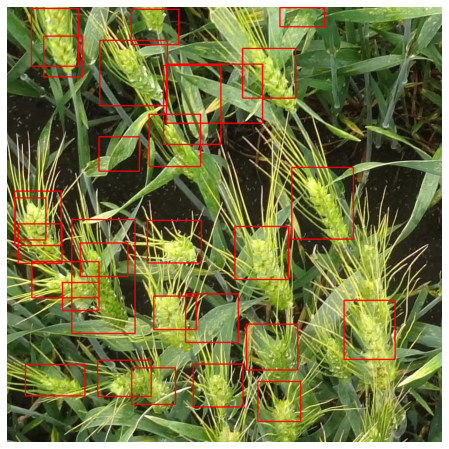

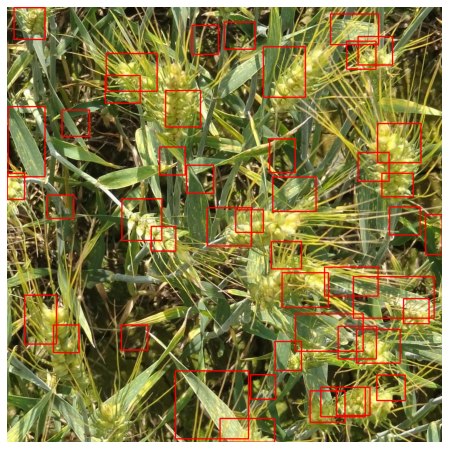

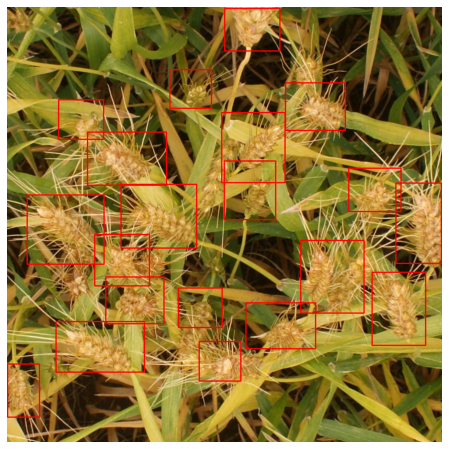

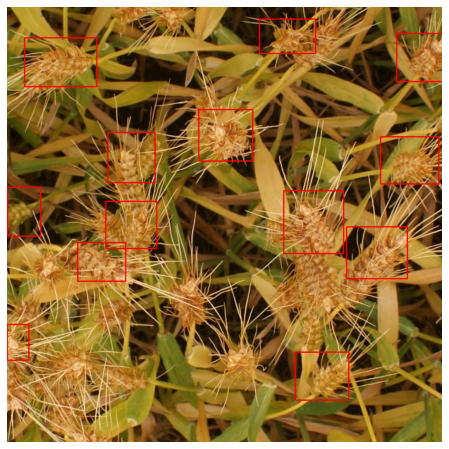

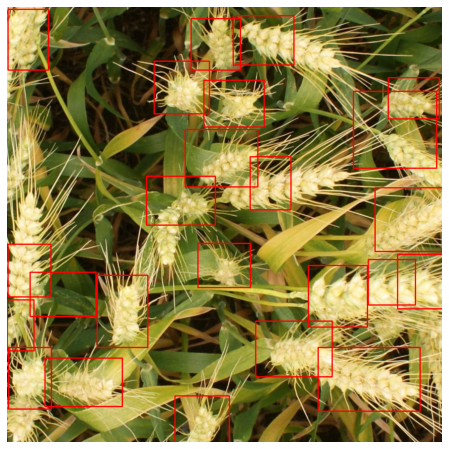

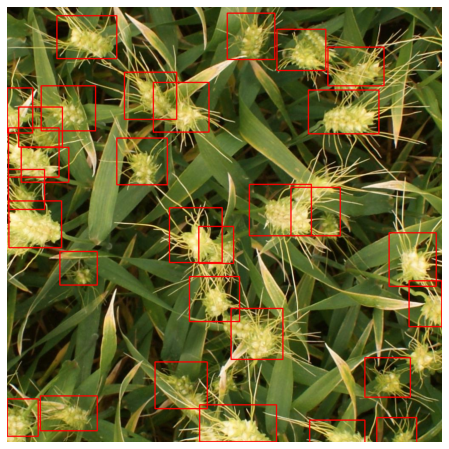

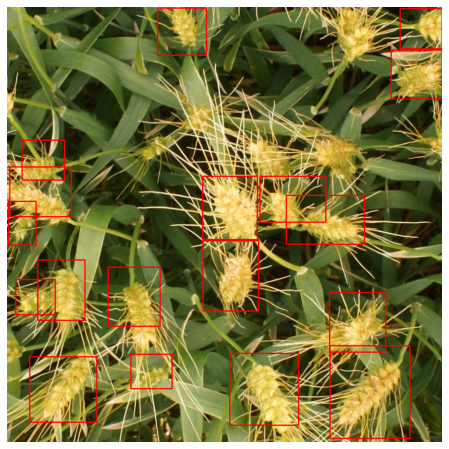

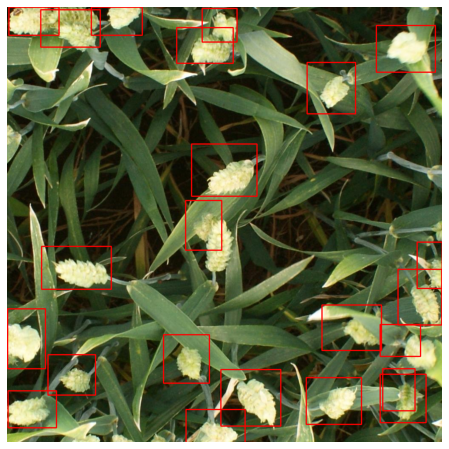

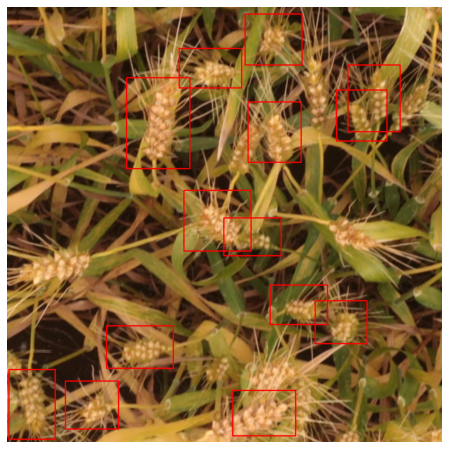

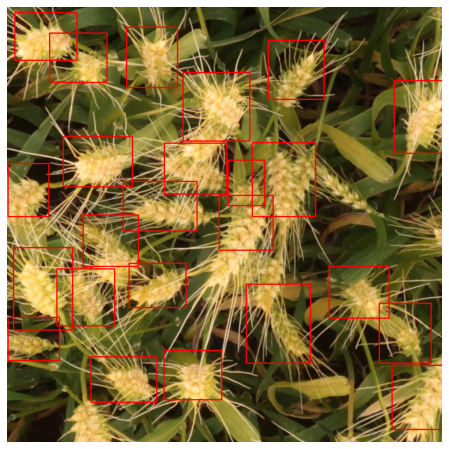

In [47]:
outputs = predict_and_view(test_data_loader, model, confidence_threshold=confidence_threshold)

In [48]:
torch.cuda.empty_cache()